# Exploratory Stuff

In [1]:
# init

from matplotlib import pyplot
import numpy as np
import pandas as pd
import pandas.io.sql as psql
import seaborn as sns

from covid19stats.common import get_db_conn

conn = get_db_conn()

sns.set(style="darkgrid")

a4_dims = (11.7, 8.27)

N=5706


,Confirmed,Deaths
Confirmed,1.000000,0.935537
Deaths,0.935537,1.000000


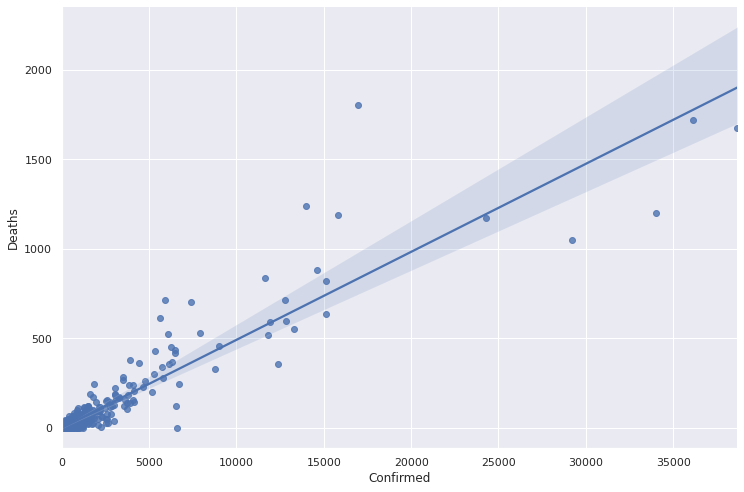

In [2]:
# sanity check: is this thing on?
# of course confirmed cases will be highly correlated with deaths, duh

sql = """
SELECT
    Confirmed,
    Deaths
FROM fact_counties_base
WHERE
    Date = '2020-05-01'
    -- exclude NYC outlier 
    AND FIPS <> '36061'
"""

df = psql.read_sql(sql, conn)
print(f"N={df.size}")

sns.lmplot(x="Confirmed", y="Deaths", data=df, height=7, aspect=1.5)

df.corr()

Is there a correlation between new cases and deaths?

Look at correlation for values on same day, and for a two-week lag for deaths.

Note that the drop on 6-11 is due to Michigan counties suddenly reporting additional deaths.
This is logged in the notes in the CSSE repo. It throws off the correlation.

In [3]:
def get_corr(df, date, col1, col2):
    new_df = df[df['Date']==date].drop(columns=['Date'])
    return new_df[col1].corr(new_df[col2])

def corr_over_time(df, col1, col2):
    pairs = [[date, get_corr(df, date, col1, col2)] for date in df['Date'].unique()]

    results = pd.DataFrame(pairs, columns = ['Date', 'Corr'])  
    results = results.sort_values(['Date'])

    results['Date']= pd.to_datetime(results['Date']) 

    return results

## new cases and deaths on same day

sql = """
SELECT
    Date,
    Avg7DayConfirmedIncrease,
    Avg7DayDeathsIncrease
FROM fact_counties_base
"""

df = psql.read_sql(sql, conn)

results = corr_over_time(df, 'Avg7DayConfirmedIncrease', 'Avg7DayDeathsIncrease')

## new cases and 2 week time lag for deaths 

sql = """
SELECT
    earlier.Date,
    earlier.Avg7DayConfirmedIncrease,
    later.Avg7DayDeathsIncrease
FROM fact_counties_base earlier
JOIN fact_counties_base later
    ON earlier.FIPS = later.FIPS
    AND date(earlier.Date) = date(later.Date, '-14 days')
"""

df_lag = psql.read_sql(sql, conn)

results_lag = corr_over_time(df_lag, 'Avg7DayConfirmedIncrease', 'Avg7DayDeathsIncrease')

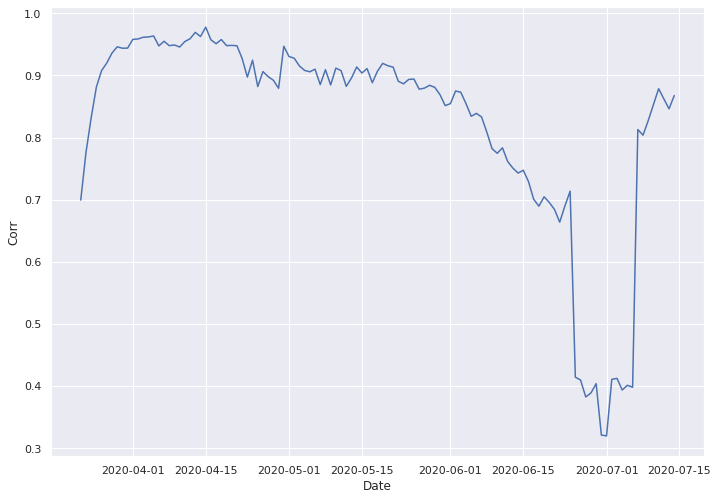

In [4]:
# Correlation for same day values

fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(x="Date", y="Corr", data=results, ax=ax);

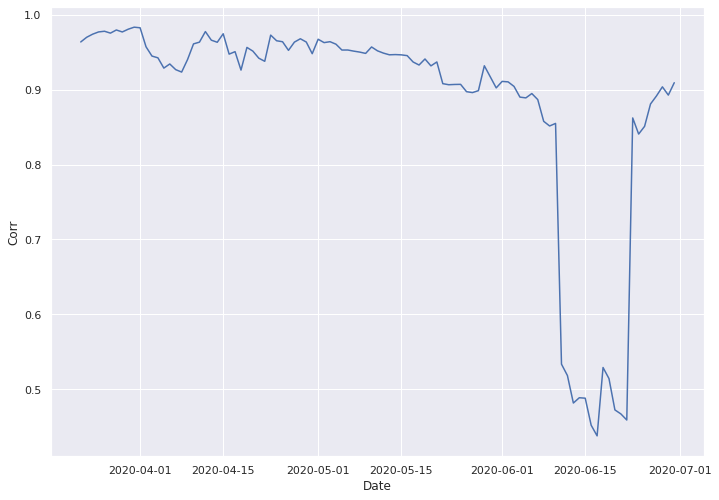

In [5]:
# Correlection, when account for Two Week Lag in Deaths

fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(x="Date", y="Corr", data=results_lag, ax=ax);

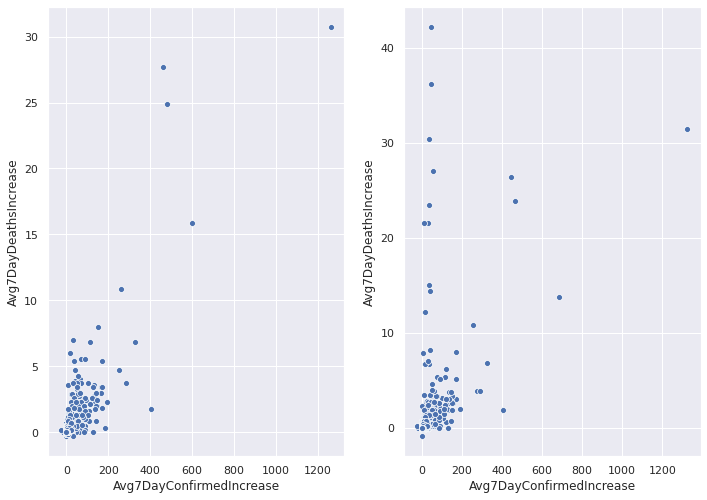

In [6]:
# notice what happens on 6-11: deaths skyrocket for a few counties. This is the Michigan issue.

fig, ax = pyplot.subplots(1, 2, figsize=a4_dims)

sns.scatterplot(x='Avg7DayConfirmedIncrease', y='Avg7DayDeathsIncrease', \
                data=df_lag[df_lag['Date']=='2020-06-10'], ax=ax[0]);

sns.scatterplot(x='Avg7DayConfirmedIncrease', y='Avg7DayDeathsIncrease', \
                data=df_lag[df_lag['Date']=='2020-06-11'], ax=ax[1]);

N=5698


,Confirmed,Population
Confirmed,1.000000,0.603974
Population,0.603974,1.000000


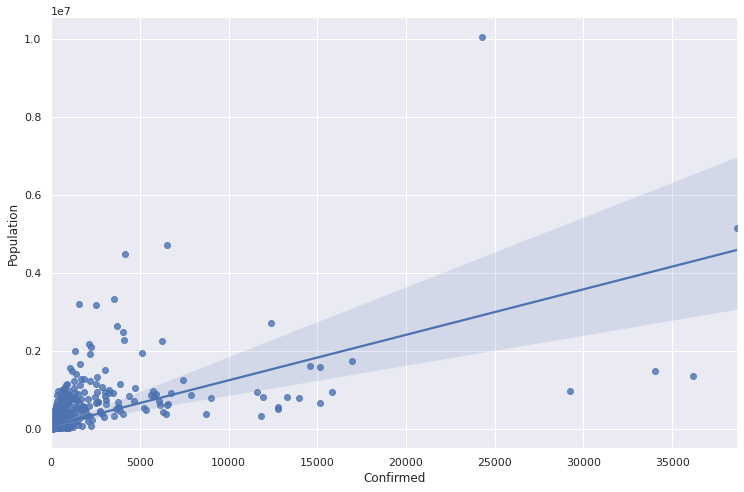

In [7]:
# is there a correlation with population size?
# we'd expect so, since outbreaks began in large cities.
# correlation probably decreases over time

sql = """
SELECT
    Confirmed,
    Population
FROM fact_counties_base b
JOIN dim_county c
    ON b.FIPS = c.FIPS
WHERE
    Date = '2020-05-01'
    AND Population > 0
    AND Confirmed >= 0
    -- exclude NYC outlier 
    AND b.FIPS <> '36061'
"""

df = psql.read_sql(sql, conn)
print(f"N={df.size}")

sns.lmplot(x="Confirmed", y="Population", data=df, height=7, aspect=1.5)

df.corr()

N=5390


,Deaths,MedianAge
Deaths,1.000000,-0.067186
MedianAge,-0.067186,1.000000


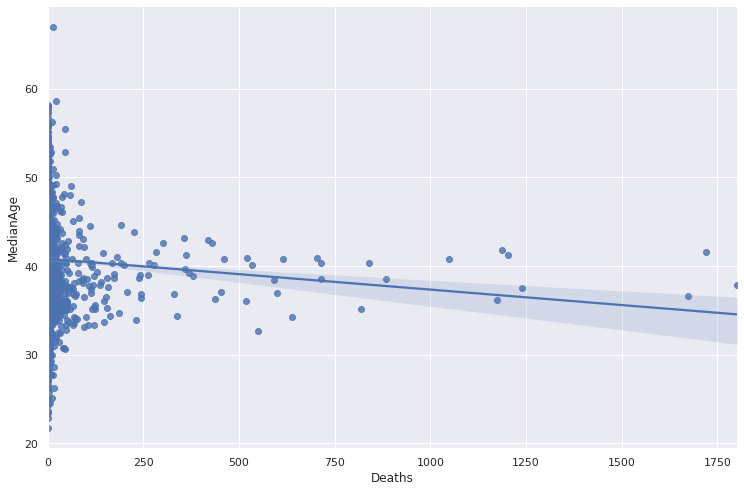

In [8]:
# no correlation with median age, which is odd

sql = """
SELECT
    Deaths,
    MedianAge
FROM fact_counties_base cr
JOIN dim_county c
    ON cr.FIPS = c.FIPS
WHERE
    Date = '2020-05-01'
    AND MedianAge > 0
    AND Deaths >= 0
    -- exclude NYC outlier 
    AND cr.FIPS <> '36061'
"""

df = psql.read_sql(sql, conn)
print(f"N={df.size}")

sns.lmplot(x="Deaths", y="MedianAge", data=df, height=7, aspect=1.5)

df.corr()

,Deaths,MedianAge
Deaths,1.000000,-0.205324
MedianAge,-0.205324,1.000000


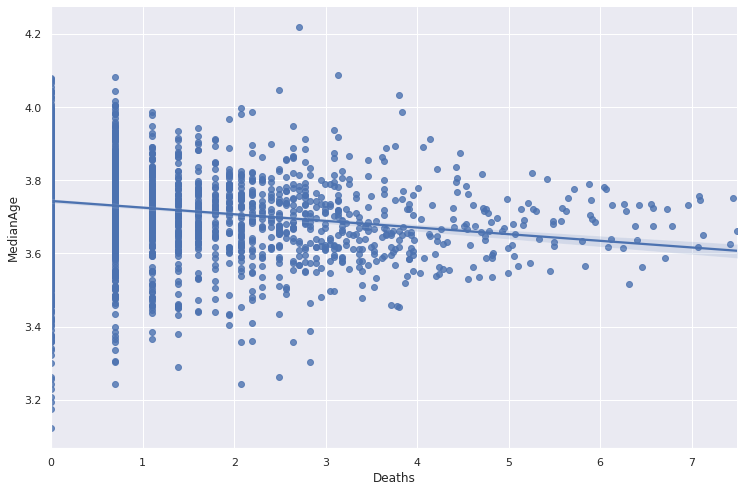

In [9]:
# try log transform to spread out the data

sns.lmplot(x="Deaths", y="MedianAge", data=np.log1p(df), height=7, aspect=1.5)

np.log1p(df).corr()

N=5388


,Confirmed,MedianIncome
Confirmed,1.000000,0.248781
MedianIncome,0.248781,1.000000


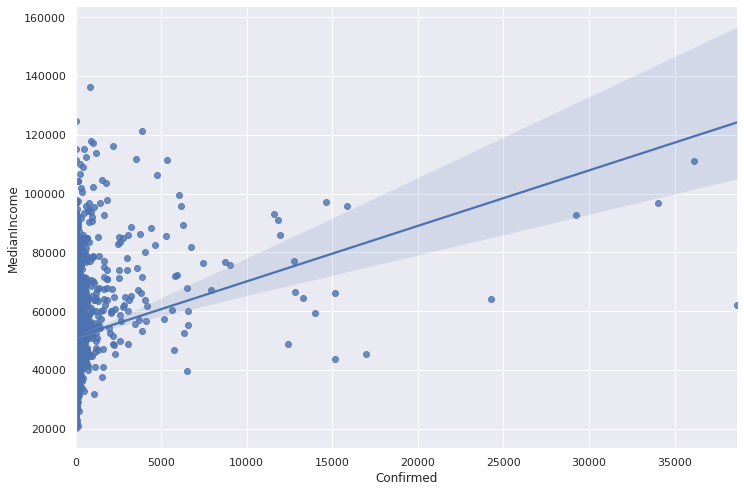

In [10]:
# very slight correlation with median income?

sql = """
SELECT
    Confirmed,
    MedianIncome
FROM fact_counties_base b
JOIN dim_county c
    ON b.FIPS = c.FIPS
WHERE
    Date = '2020-05-01'
    AND MedianIncome > 0
    AND Confirmed >= 0
    -- exclude NYC outlier 
    AND b.FIPS <> '36061'
"""

df = psql.read_sql(sql, conn)
print(f"N={df.size}")

sns.lmplot(x="Confirmed", y="MedianIncome", data=df, height=7, aspect=1.5)

df.corr()

N=5388


,ConfirmedPer1M,MedianIncome
ConfirmedPer1M,1.000000,0.092792
MedianIncome,0.092792,1.000000


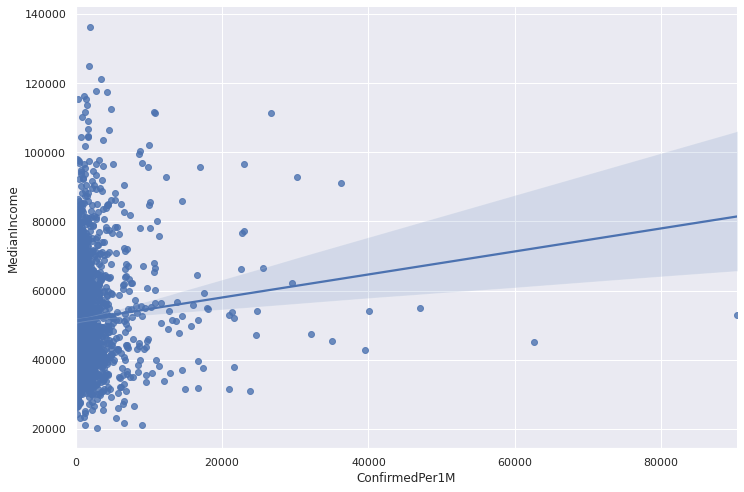

In [11]:
# try median income again, but with ConfirmedPer1M this time.
# it's not clear to me whether you can use counts adjusted to the pop in calculating correlation coefficient

sql = """
SELECT
    ConfirmedPer1M,
    MedianIncome
FROM fact_counties_ranked cr
JOIN dim_county c
    ON cr.FIPS = c.FIPS
WHERE
    Date = '2020-05-01'
    AND MedianIncome > 0
    AND ConfirmedPer1M >= 0
    -- exclude NYC outlier 
    AND cr.FIPS <> '36061'
"""

df = psql.read_sql(sql, conn)
print(f"N={df.size}")

sns.lmplot(x="ConfirmedPer1M", y="MedianIncome", data=df, height=7, aspect=1.5)

df.corr()